# 0. Preparación del entorno

In [1]:
import os

import uuid
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from google.colab import drive
from statsmodels.tsa.stattools import acf

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
os.environ['RUTA_SIMULACIONES'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/simulaciones/'
os.environ['RUTA_DATASETS'] = '/content/drive/MyDrive/UCLM/MUII/TFM/code/src/data/datasets/'
os.environ['ORIGEN_DATASET_CONSUMOS'] = 'consumos_casas_1-99'
os.environ['ORIGEN_DATASET_EVENTOS'] = ''
os.environ['MAX_HOUSE_LOAD'] = '99'
os.environ['DESTINO_DATASET_CONSUMOS'] = f'consumos_casas_1-{os.environ.get("MAX_HOUSE_LOAD")}'
os.environ['DESTINO_DATASET_EVENTOS'] = f'eventos_casas_1-{os.environ.get("MAX_HOUSE_LOAD")}_v2_int_norm'

# 1. Arquitectura

## 1.1. Modelos

### Evento

- **reducir_extremos_serie(umbral_residuo: int = 3)**: Reduce los extremos de una serie de 2 o más minutos de duración.

  Si una serie tiene en un extremo un consumo de 1L, pero la posición contigua tiene un consumo mayor (establecido este umbral llamado como umbral residuo en >= 3L) se considera que el consumo del extremo realmente no refleja la intensidad del evento completo. Por lo tanto, extre consumo se agrega al consumo de la posición contigua, de manera que no afecte tan notablemente en el cálculo de la intensidad.

In [4]:
class Evento():
  def __init__(self, min_inicio: int, id_consumo_origen: str, serie_evento: list[int] = None, id_evento: str = None, std_norm: float = None):
    if id_evento is None:
      id_evento = str(uuid.uuid4())
    if serie_evento is None:
      serie_evento = []
    self.id = id_evento
    self.min_inicio = min_inicio
    self.id_consumo_origen = id_consumo_origen
    self.consumo_min_vol = None
    self.consumo_max_vol = None
    self._serie = serie_evento
    self._std_norm = None

  def __dict__(self):
    return {
            'id': self.id,
            'id_consumo_origen': self.id_consumo_origen,
            'min_inicio': self.min_inicio,
            'min_fin': self.obtener_min_fin(),
            'serie': self._serie,
          }

  def obtener_serie(self) -> list[int]:
    return [*self._serie]

  def obtener_caracteristicas(self):
    return {
        **self.__dict__(),
        'total_vol': self.obtener_total_vol(),
        'max_vol': max(self._serie),
        'max_vol_norm': self.obtener_max_vol_norm(),
        'duracion': self.obtener_duracion(),
        'intensidad': self.obtener_intensidad(),
        'intensidad_norm': self.obtener_intensidad_norm(),
        'std_norm': self.obtener_std_norm()
    }

  def obtener_min_fin(self) -> int:
    return self.min_inicio + len(self._serie)

  def obtener_duracion(self) -> int:
    return len(self._serie)

  def obtener_max_vol_norm(self) -> float:
    if self.consumo_min_vol is None or self.consumo_max_vol is None:
      raise ValueError("No se han podido leer los valores máximo y mínimo del consumo origen.")
    evento_max_vol = max(self._serie)
    return (evento_max_vol - self.consumo_min_vol) / (self.consumo_max_vol - self.consumo_min_vol)

  def obtener_total_vol(self) -> int:
    return sum(self._serie)

  def obtener_intensidad(self) -> float:
    return self.obtener_total_vol() / self.obtener_duracion()

  def obtener_intensidad_norm(self) -> float:
    if self.consumo_min_vol is None or self.consumo_max_vol is None:
      raise ValueError("No se han podido leer los valores máximo y mínimo del consumo origen.")
    evento_intensidad = self.obtener_total_vol() / self.obtener_duracion()
    return (evento_intensidad - self.consumo_min_vol) / (self.consumo_max_vol - self.consumo_min_vol)

  def obtener_std_norm(self) -> float:
    if self._std_norm is None:
      if self.consumo_min_vol is None or self.consumo_max_vol is None:
        raise ValueError("No se han podido leer los valores máximo y mínimo del consumo origen.")
      self._std_norm = np.std((np.array([*self._serie]) - self.consumo_min_vol) / (self.consumo_max_vol - self.consumo_min_vol)) if self.obtener_duracion() > 1 else 0
    return self._std_norm

  def ampliar_serie_con_valor(self, valor: int):
    self._serie.append(valor)

  def ampliar_serie_con_serie(self, nueva_serie: list[int]):
    self._serie += nueva_serie

  def reducir_extremos_serie(self):
    serie_reducida = [*self._serie]
    if len(self._serie) == 2:
      if self._serie[1] >= self._serie[0] * 3: # Comprobación en el primer minuto
        serie_reducida = [self._serie[0] + self._serie[1]]
        self.min_inicio += 1
      elif self._serie[0] >= self._serie[1] * 3: # Comprobación en el primer minuto
        serie_reducida = [self._serie[0] + self._serie[1]]
    elif len(self._serie) > 2:
      if self._serie[1] >= self._serie[0] * 3: # Comprobación en el primer minuto
        serie_reducida = [self._serie[0] + self._serie[1], *self._serie[2:]]
        self.min_inicio += 1
      serie_aux = [*serie_reducida[::-1]]
      if serie_aux[1] >= serie_aux[0] * 3: # Comprobación en el último minuto
        serie_aux = [serie_aux[0] + serie_aux[1], *serie_aux[2:]]
      serie_reducida = serie_aux[::-1]
    self._serie = [*serie_reducida]

  def actualizar_consumo_min_max_vol(self, consumo_min_vol: int, consumo_max_vol: int):
    self.consumo_min_vol = consumo_min_vol
    self.consumo_max_vol = consumo_max_vol



### Consumo

In [5]:
class Consumo:
  def __init__(self, dia: int, casa: str, parte: int = 0, serie: list[int] = []):
    self.dia: int = dia
    self.casa: str = casa
    self.parte: int = parte
    self._serie: list[int] = serie
    self._lista_eventos: list[Evento] = []

  def obtener_id(self) -> str:
    id_consumo = f"{self.casa}_Day{self.dia}"
    if self.parte != 0:
      id_consumo += f"_part{self.parte}"
    return id_consumo

  def obtener_serie(self) -> list[int]:
    return [*self._serie]

  def leer_serie(self):
    self._serie = leer_consumo_excel(self.dia, self.casa, self.parte)

  def obtener_lista_eac(self, consumo_minimo: int = 8) -> list[Evento]:
    lista_eac = []
    for e in self.obtener_lista_eventos():
      if sum(e.obtener_serie()) >= consumo_minimo:
        lista_eac.append(e)
    return lista_eac

  def obtener_lista_ecacld(self, duracion_minima: int = 5, intensidad_minima: int = 5) -> list[Evento]:
    lista_ecacld = []
    for e in self.obtener_lista_eac():
      if len(e.obtener_serie()) >= duracion_minima and \
        sum(e.obtener_serie()) / len(e.obtener_serie()) >= intensidad_minima:
        lista_ecacld.append(e)
    return lista_ecacld

  def obtener_lista_eccd(self, duracion_maxima: int = 4) -> list[Evento]:
    lista_eccd = []
    for e in self.obtener_lista_eac():
      if len(e.obtener_serie()) <= duracion_maxima:
        lista_eccd.append(e)
    return lista_eccd

  def obtener_lista_ebc(self, consumo_maximo: int = 7) -> list[Evento]:
    lista_ebc = []
    for e in self.obtener_lista_eventos_relevantes():
      if sum(e.obtener_serie()) <= consumo_maximo:
        lista_ebc.append(e)
    return lista_ebc

  def obtener_lista_eventos(self):
    if not self._lista_eventos:
      evento = None
      for m, c in zip(range(len(self._serie)), self._serie):
        if c == 0:
          if not evento:
            continue
          else:
            evento.reducir_extremos_serie()
            self._lista_eventos.append(evento)
            evento = None
        elif c > 0:
          if not evento:
            evento = Evento(m, self.obtener_id())
          evento.ampliar_serie_con_valor(c)
    return [*self._lista_eventos]

  def generar_lista_eventos_relevantes(self, consumo_minimo_relevante: int = 2):
    self._lista_eventos = []
    for e in self.obtener_lista_eventos():
      if max(e.obtener_serie()) >= consumo_minimo_relevante:
        self._lista_eventos.append(e)

  def obtener_lista_eventos_relevantes(self, recalcular: bool = False) -> list[Evento]:
    if recalcular:
      self.generar_lista_eventos_relevantes()
    return [*self._lista_eventos]

  def agregar_evento(self, nuevo_evento: Evento):
    self._lista_eventos.append(nuevo_evento)

  def obtener_min_max_vol(self) -> tuple:
    lista_eventos: list[Evento] = self.obtener_lista_eventos_relevantes()
    max_vol: int = max([max(e.obtener_serie()) for e in lista_eventos])
    min_vol: int = min([min(e.obtener_serie()) for e in lista_eventos])
    return (min_vol, max_vol)

  def actualizar_eventos_min_max_vol(self):
    lista_eventos: list[Evento] = self.obtener_lista_eventos_relevantes()
    for evento in lista_eventos:
      evento.actualizar_consumo_min_max_vol(*self.obtener_min_max_vol())


### Grupo Consumos

In [6]:
class GrupoConsumos:
  def __init__(self):
    self._consumos: list[Consumo] = []
    self._n_consumos = 0
    self.dataset_eventos = None

  def obtener_consumos(self) -> list[Consumo]:
    return [*self._consumos]

  def obtener_consumo(self, dia: int, casa: str, parte: int = 0) -> Consumo:
    return next((c for c in self._consumos if c.dia == dia and c.casa == casa and c.parte == parte), None)

  def obtener_consumo_por_id(self, id: str) -> Consumo:
    return next((c for c in self._consumos if c.obtener_id() == id), None)

  def obtener_consumo_por_id_evento(self, id_evento: str) -> Consumo:
    for c in self._consumos:
      for e in c.obtener_lista_eventos():
        if e.id == id_evento:
          return self.obtener_consumo_por_id(e.id_consumo_origen)

  def add_consumo(self, consumo: Consumo):
    self._consumos.append(consumo)
    self._n_consumos += 1

  def guardar_como_excel(self, nombre_archivo: str = 'consumos_casas_1-100'):
    data = []
    for consumo in self._consumos:
      data.append({
        'dia': consumo.dia,
        'casa': consumo.casa,
        'parte': consumo.parte,
        'serie': consumo.obtener_serie()
      })
    df = pd.DataFrame(data)
    df.to_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index=False)

  def carga_desde_excel(self, nombre_archivo: str):
    df = pd.read_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx")
    self._consumos = []
    self._n_consumos = 0
    for _, row in df.iterrows():
      consumo = Consumo(row['dia'], row['casa'], row['parte'], eval(row['serie']))
      self.add_consumo(consumo)

  def guardar_dataset_eventos(self, nombre_archivo: str, crear_si_no_existe: bool = False):
    if not self.dataset_eventos and not crear_si_no_existe:
      print("El dataset de eventos no está creado.")
      return
    elif not self.dataset_eventos and crear_si_no_existe:
      print("Creando el dataset de eventos...")
      self.crear_dataset_eventos()

    self.dataset_eventos.to_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index=True)

  def leer_dataset_eventos(self, nombre_archivo: str):
    if not self._consumos:
      print('[WARNING] No se ha leido el dataset de consumos. No se crearán las instancias de los objetos.')
    self.dataset_eventos = pd.read_excel(f"{os.environ.get('RUTA_DATASETS')}{nombre_archivo}.xlsx", index_col="id")
    if self._consumos:
      for index, fila in self.dataset_eventos.iterrows():
        consumo = self.obtener_consumo_por_id(fila['id_consumo_origen'])
        consumo.agregar_evento(Evento(fila['min_inicio'], fila['id_consumo_origen'], serie_evento = eval(fila['serie']), id_evento = index, std_norm=fila['std_norm']))
      consumo.actualizar_eventos_min_max_vol()
    return self.dataset_eventos

  def crear_dataset_eventos(self):
    filas = []
    lista_eventos = self.obtener_eventos()
    for e in lista_eventos:
      filas.append(e.obtener_caracteristicas())
    self.dataset_eventos = pd.DataFrame(filas).set_index('id')
    return self.dataset_eventos

  def obtener_eventos(self):
    eventos: list[Evento] = []
    for c in self.obtener_consumos():
      c.generar_lista_eventos_relevantes()
      c.actualizar_eventos_min_max_vol()
      eventos += c.obtener_lista_eventos_relevantes()
    return eventos

## 1.2. Utils

### Carga y procesamiento de datos de consumo

In [7]:
def obtener_ruta_archivo(nombre: str, parte: int = 0):
  ruta_archivo = f"{os.environ.get('RUTA_SIMULACIONES')}{nombre}"
  if parte != 0:
    ruta_archivo += f"_part{parte}"
  ruta_archivo += ".xlsx"
  return ruta_archivo

assert obtener_ruta_archivo("House1", 1) == os.environ.get('RUTA_SIMULACIONES') + 'House1_part1.xlsx'
assert obtener_ruta_archivo("House1", 0) == os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx'

In [8]:
def obtener_n_dias(ruta_archivo: str):
  xls = pd.ExcelFile(ruta_archivo)
  return len([d for d in xls.sheet_names if d.startswith('Day')]);

assert obtener_n_dias(os.environ.get('RUTA_SIMULACIONES') + 'House1.xlsx') == 10

In [9]:
def leer_consumo_excel(dia: int, casa: str, parte: int = 0):
  serie = pd.read_excel(obtener_ruta_archivo(casa, parte), sheet_name=f'Day{dia}', header=None).iloc[0]
  data = [int(x) for x in serie if not isinstance(x, str)]
  return data

### Visualización

In [10]:
def visualizar_serie_temporal(serie: list[int], titulo_plt: str, titulo_x: str, titulo_y: str, color: str = 'blue', figsize = (20, 5), x_inicio: int = 0, x_fin: int = 1440, x_intervalo: int = 1, x_rotacion_etiquetas: float = 90.0):
  plt.figure(figsize=figsize)
  plt.bar(range(x_inicio, x_fin), serie, color=color)
  plt.xlabel(titulo_x)
  plt.ylabel(titulo_y)
  plt.title(titulo_plt)
  plt.xticks(range(x_inicio, x_fin, x_intervalo), rotation=x_rotacion_etiquetas)
  plt.show()

### Tratamiento de eventos

In [11]:
def construir_serie_desde_eventos(lista_eventos: list[Evento], acotada: bool = True):
  if not lista_eventos:
    return [0] * 1440

  lista_eventos.sort(key=lambda evento: evento.min_inicio)
  ultimo_evento = lista_eventos[0]
  serie = [*ultimo_evento.obtener_serie()]

  for e in lista_eventos[1:]:
    if ultimo_evento.obtener_min_fin() <= e.min_inicio:
      serie += [0] * (e.min_inicio - ultimo_evento.obtener_min_fin())
      serie += e.obtener_serie()
      ultimo_evento = e
    else:
      pass

  if not acotada:
    serie = [*([0] * lista_eventos[0].min_inicio), *serie, *([0] * (1440 - lista_eventos[::-1][0].obtener_min_fin()))]

  return serie


### Recategorización de eventos sin grupo

In [12]:
def extraer_posibles_fragmentos_de_ed(df_cluster_sin_grupo: pd.DataFrame) -> pd.DataFrame:
  df_cluster_sin_grupo["posible_frag_ed"] = 0
  for idx, row in df_cluster_sin_grupo.iterrows():
    if row["duracion"] <= 3 and row["total_vol"] >= 9:
      df_cluster_sin_grupo.at[idx, "posible_frag_ed"] = 1
  return df_cluster_sin_grupo


## 1.3. Algoritmo de clustering borroso

### Conjuntos Borrosos

`Prototipos` | **max_vol**  | **duracion** | **intensidad** | **total_vol**
--- | --- | --- | --- | ---
**Grupo 1** | Alto | Larga | Fuerte | Alto
**Grupo 2** | Alto | Corta | Fuerte | Alto
**Grupo 3** | Medio | Corta | Media | Medio
**Grupo 4** | Bajo | Corta | Media | Medio
**Grupo 5** | Bajo | Corta | Débil | Bajo

In [13]:
class ConjuntoBorroso():
  def calcular_grados_pertenencia(self, valor: float | int) -> dict:
    return {
        "c1": round(self.fun_pert_bajo(valor), 3),
        "c2": round(self.fun_pert_medio(valor), 3),
        "c3": round(self.fun_pert_alto(valor), 3),
    }

  def fun_pert_bajo(self, valor: float | int) -> float:
    raise NotImplementedError("Este método debe implementarlo la subclase.")

  def fun_pert_medio(self, valor: float | int) -> float:
    raise NotImplementedError("Este método debe implementarlo la subclase.")

  def fun_pert_alto(self, valor: float | int) -> float:
    raise NotImplementedError("Este método debe implementarlo la subclase.")


#### Conjunto del volumen máximo

In [14]:
class MaxVolConjunto(ConjuntoBorroso):

  def fun_pert_bajo(self, valor: float | int) -> float:
    a = 0.1
    b = 0.4

    if valor <= a:
      return 1

    elif valor >= b:
      return 0

    else:
      return (b - valor) / (b - a)

  def fun_pert_medio(self, valor: float | int) -> float:
    a = 0.3
    b = 0.4
    c = 0.5
    d = 0.8

    if valor >= b and valor <= c:
      return 1

    elif valor <= a or valor >= d:
      return 0

    elif valor > a and valor < b:
      return (valor - a) / (b - a)

    else:
      return (d - valor) / (d - c)

  def fun_pert_alto(self, valor: float | int) -> float:
    a = 0.6
    b = 0.8

    if valor >= b:
      return 1

    elif valor <= a:
      return 0

    else:
      return (valor - a) / (b - a)


#### Conjunto de la duración

In [15]:
class DuracionConjunto(ConjuntoBorroso):

  def fun_pert_bajo(self, valor: float | int) -> float:
    a = 1
    b = 4

    if valor <= a:
      return 1

    elif valor >= b:
      return 0

    else:
      return (b - valor) / (b - a)

  def fun_pert_medio(self, valor: float | int) -> float:
    a = 2
    b = 4
    c = 6

    if valor == b:
      return 1

    elif valor <= a or valor >= c:
      return 0

    elif valor > a and valor < b:
      return (valor - a) / (b - a)

    else:
      return (c - valor) / (c - b)

  def fun_pert_alto(self, valor: float | int) -> float:
    a = 4
    b = 6

    if valor >= b:
      return 1

    elif valor <= a:
      return 0

    else:
      return (valor - a) / (b - a)


#### Conjunto de la intensidad

In [16]:
class IntensidadConjunto(ConjuntoBorroso):

  def fun_pert_bajo(self, valor: float | int) -> float:
    a = 2
    b = 3.5

    if valor <= a:
      return 1

    elif valor >= b:
      return 0

    else:
      return (b - valor) / (b - a)

  def fun_pert_medio(self, valor: float | int) -> float:
    a = 2.5
    b = 4
    c = 5.5
    d = 6.5

    if valor >= b and valor <= c:
      return 1

    elif valor <= a or valor >= d:
      return 0

    elif valor > a and valor < b:
      return (valor - a) / (b - a)

    else:
      return (d - valor) / (d - c)

  def fun_pert_alto(self, valor: float | int) -> float:
    a = 5.5
    b = 6.5

    if valor >= b:
      return 1

    elif valor <= a:
      return 0

    else:
      return (valor - a) / (b - a)


#### Conjunto del volumen total

In [17]:
class TotalVolConjunto(ConjuntoBorroso):

  def fun_pert_bajo(self, valor: float | int) -> float:
    a = 4
    b = 6

    if valor <= a:
      return 1

    elif valor >= b:
      return 0

    else:
      return (b - valor) / (b - a)

  def fun_pert_medio(self, valor: float | int) -> float:
    a = 5
    b = 10
    c = 20
    d = 30

    if valor >= b and valor <= c:
      return 1

    elif valor <= a or valor >= d:
      return 0

    elif valor > a and valor < b:
      return (valor - a) / (b - a)

    else:
      return (d - valor) / (d - c)

  def fun_pert_alto(self, valor: float | int) -> float:
    a = 20
    b = 30

    if valor >= b:
      return 1

    elif valor <= a:
      return 0

    else:
      return (valor - a) / (b - a)


### Modelo de clustering

In [18]:
class Muestra():
  def __init__(self, evento: Evento, grados_pertenencia: list[float] = None):
    if grados_pertenencia is None:
      grados_pertenencia = []
    self.id_muestra = evento.id
    self.max_vol = evento.obtener_max_vol_norm()
    self.duracion = evento.obtener_duracion()
    self.intensidad = evento.obtener_intensidad()
    self.total_vol = evento.obtener_total_vol()
    self._serie_evento = evento.obtener_serie()
    self.grados_pertenencia = grados_pertenencia

  def obtener_caracteristicas(self):
    return {
        "id_muestra": self.id_muestra,
        "serie": self._serie_evento,
        "max_vol": self.max_vol,
        "duracion": self.duracion,
        "intensidad": self.intensidad,
        "total_vol": self.total_vol,
        "gp_g1": self.grados_pertenencia[0],
        "gp_g2": self.grados_pertenencia[1],
        "gp_g3": self.grados_pertenencia[2],
        "gp_g4": self.grados_pertenencia[3],
        "gp_g5": self.grados_pertenencia[4]
    }


In [19]:
class FuzzyClusteringEventos():
  def __init__(self):
    self._lista_muestras = []

  def obtener_grados_pertenencia_patrones(self, muestra: Muestra):
    grados_pertenencia_g1 = [
        MaxVolConjunto().calcular_grados_pertenencia(muestra.max_vol)['c3'],
        DuracionConjunto().calcular_grados_pertenencia(muestra.duracion)['c3'],
        IntensidadConjunto().calcular_grados_pertenencia(muestra.intensidad)['c3'],
        TotalVolConjunto().calcular_grados_pertenencia(muestra.total_vol)['c3']
    ]
    grados_pertenencia_g2 = [
        MaxVolConjunto().calcular_grados_pertenencia(muestra.max_vol)['c3'],
        DuracionConjunto().calcular_grados_pertenencia(muestra.duracion)['c1'],
        IntensidadConjunto().calcular_grados_pertenencia(muestra.intensidad)['c2'],
        TotalVolConjunto().calcular_grados_pertenencia(muestra.total_vol)['c2']
    ]
    grados_pertenencia_g3 = [
        MaxVolConjunto().calcular_grados_pertenencia(muestra.max_vol)['c2'],
        DuracionConjunto().calcular_grados_pertenencia(muestra.duracion)['c1'],
        IntensidadConjunto().calcular_grados_pertenencia(muestra.intensidad)['c3'],
        TotalVolConjunto().calcular_grados_pertenencia(muestra.total_vol)['c2']
    ]
    grados_pertenencia_g4 = [
        MaxVolConjunto().calcular_grados_pertenencia(muestra.max_vol)['c1'],
        DuracionConjunto().calcular_grados_pertenencia(muestra.duracion)['c1'],
        IntensidadConjunto().calcular_grados_pertenencia(muestra.intensidad)['c2'],
        TotalVolConjunto().calcular_grados_pertenencia(muestra.total_vol)['c2']
    ]
    grados_pertenencia_g5 = [
        MaxVolConjunto().calcular_grados_pertenencia(muestra.max_vol)['c1'],
        DuracionConjunto().calcular_grados_pertenencia(muestra.duracion)['c1'],
        IntensidadConjunto().calcular_grados_pertenencia(muestra.intensidad)['c1'],
        TotalVolConjunto().calcular_grados_pertenencia(muestra.total_vol)['c1']
    ]
    muestra.grados_pertenencia = [
        min(grados_pertenencia_g1),
        min(grados_pertenencia_g2),
        min(grados_pertenencia_g3),
        min(grados_pertenencia_g4),
        min(grados_pertenencia_g5)
    ]

  def fit(self, lista_eventos: list[Evento]):
    for evento in lista_eventos:
      muestra = Muestra(evento)
      self.obtener_grados_pertenencia_patrones(muestra)
      self._lista_muestras.append(muestra)

  def obtener_dataset_resultados(self):
    filas = [muestra.obtener_caracteristicas() for muestra in self._lista_muestras]
    dataset_muestras = pd.DataFrame(filas).set_index('id_muestra')
    return dataset_muestras



# 2. Ejecución

### 2.1. Generación o lectura del dataset con todas las series temporales de consumo

In [20]:
consumos_simulados = GrupoConsumos()
origen_dataset_consumos = os.environ.get('ORIGEN_DATASET_CONSUMOS')

if origen_dataset_consumos == '':
  for i in range(1, int(os.environ.get('MAX_HOUSE_LOAD')) + 1):
    casa = f"House{i}"
    for d in range(1, obtener_n_dias(obtener_ruta_archivo(casa)) + 1):
      consumo = Consumo(d, casa)
      consumo.leer_serie()
      consumos_simulados.add_consumo(consumo)
  consumos_simulados.guardar_como_excel(os.environ.get('DESTINO_DATASET_CONSUMOS'))
else:
  consumos_simulados.carga_desde_excel(origen_dataset_consumos)

## 2.2. Generación o lectura del dataset de todos los eventos relevantes

In [21]:
origen_dataset_eventos = os.environ.get('ORIGEN_DATASET_EVENTOS')
if origen_dataset_eventos == '':
  consumos_simulados.guardar_dataset_eventos(os.environ.get('DESTINO_DATASET_EVENTOS'), True)
else:
  consumos_simulados.leer_dataset_eventos(origen_dataset_eventos)

Creando el dataset de eventos...


# 3. Estudio de los datos

## 3.1. Series simuladas

### 3.1.1. Representación gráfica de la serie temporal

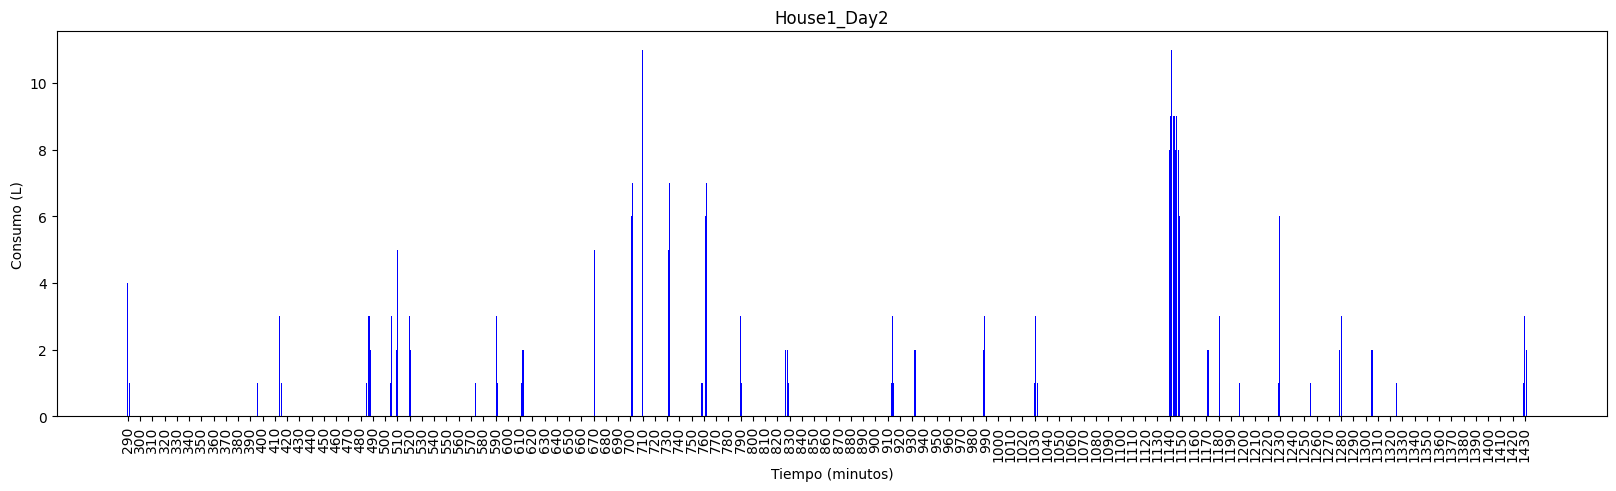

In [22]:
consumo_ejemplo = next(consumo for consumo in consumos_simulados.obtener_consumos() if max(consumo.obtener_serie()) > 7 and sum(consumo.obtener_serie()) > 150)
consumo_ejemplo = consumos_simulados.obtener_consumo(1, "House10")
consumo_ejemplo = consumos_simulados.obtener_consumos()[1]

inicio = 290
fin = 1440
serie_ejemplo = consumo_ejemplo.obtener_serie()[inicio:fin]

visualizar_serie_temporal(serie_ejemplo, consumo_ejemplo.obtener_id(), 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10, )


### 3.1.2. División en alto consumo y bajo consumo

#### Tratamiento de alto consumo

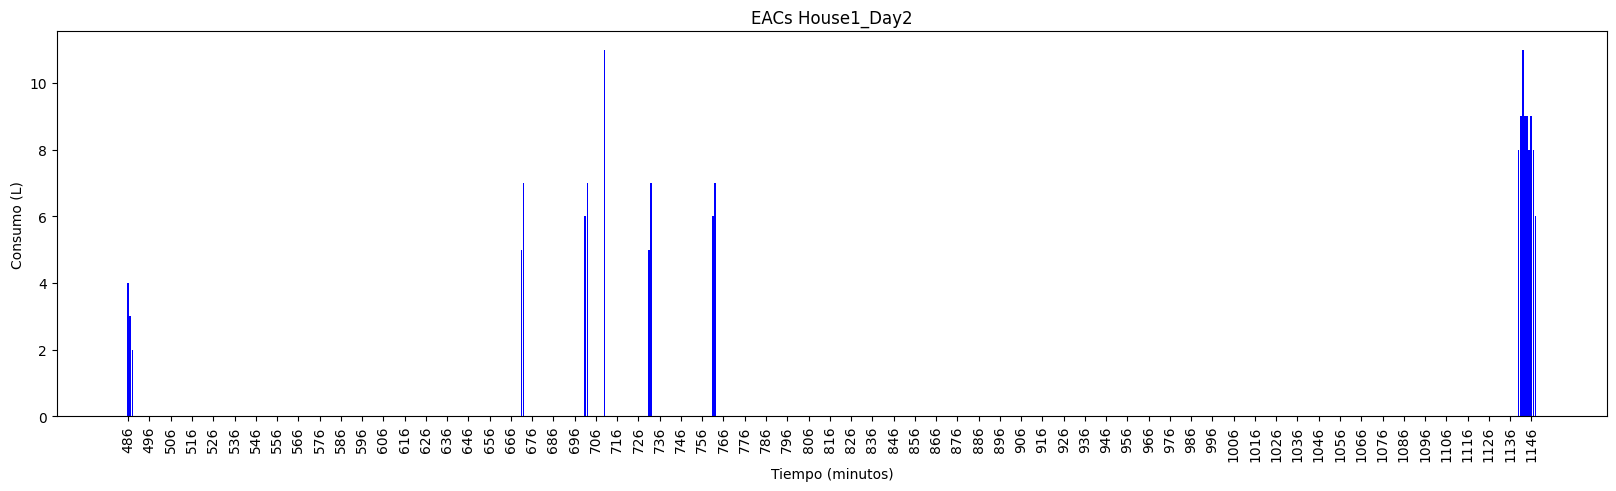

In [23]:
eventos = consumo_ejemplo.obtener_lista_eac()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'EACs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

##### Extracción de eventos continuos de alto consumo y de larga duración

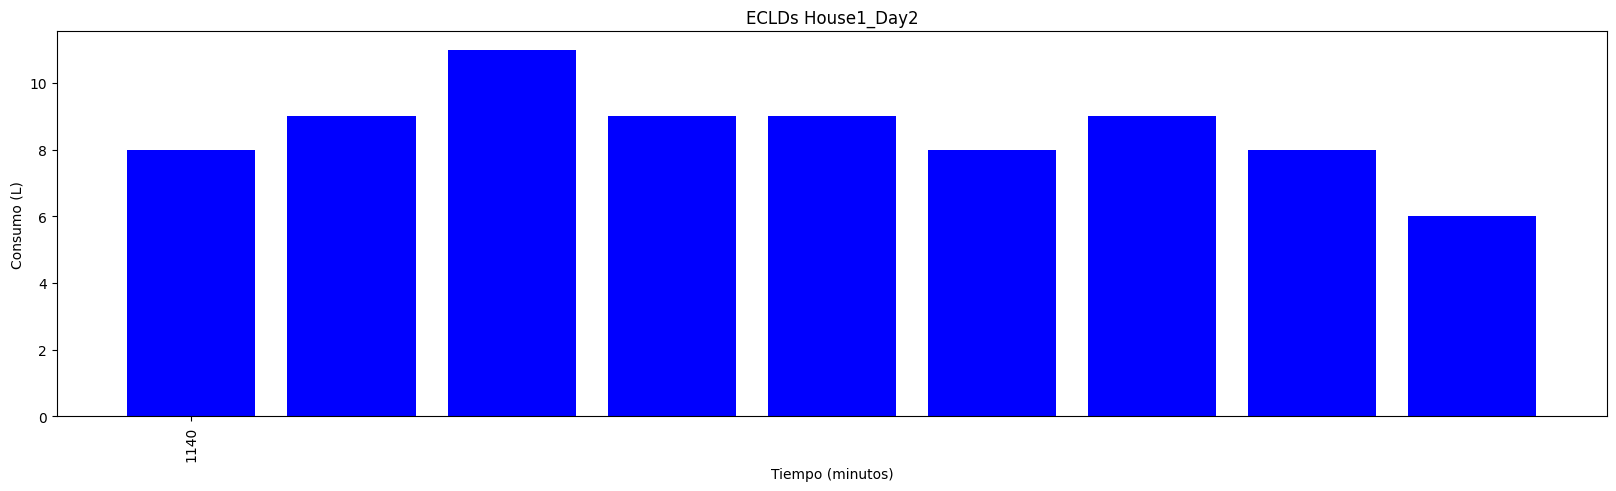

In [24]:
eventos = consumo_ejemplo.obtener_lista_ecacld()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'ECLDs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

##### Extracción de eventos continuos de corta duración

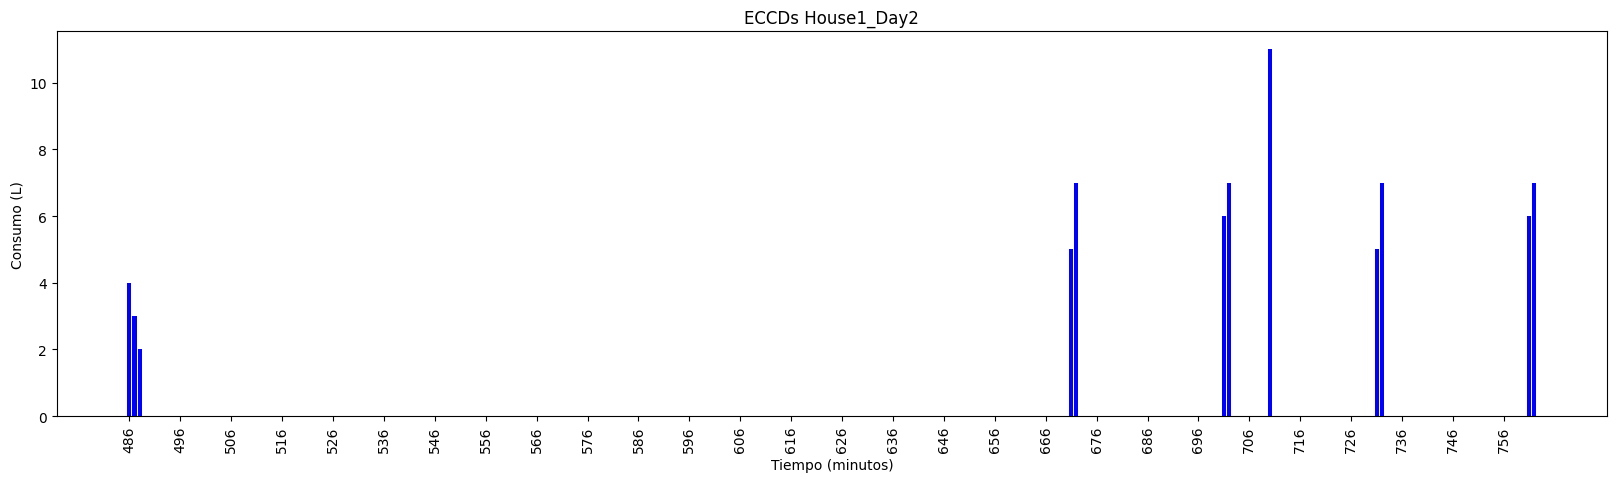

In [25]:
eventos = consumo_ejemplo.obtener_lista_eccd()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'ECCDs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

#### Tratamiento de bajo consumo

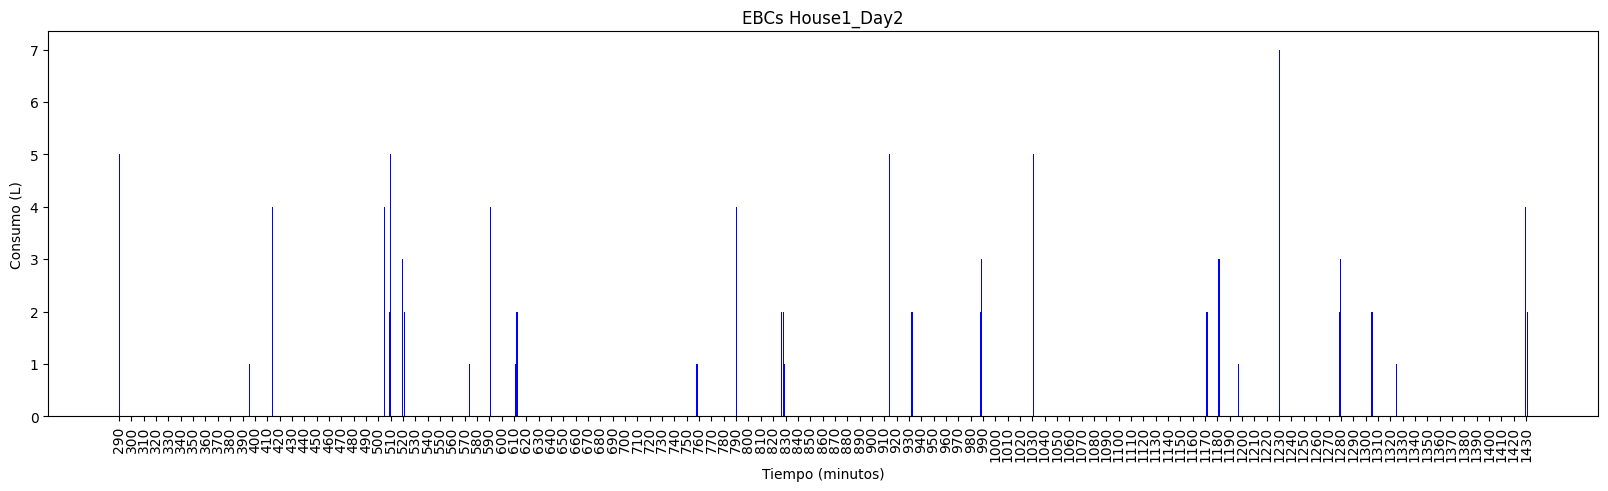

In [26]:
eventos = consumo_ejemplo.obtener_lista_ebc()

serie_ejemplo = construir_serie_desde_eventos(eventos, True)
inicio = eventos[0].min_inicio if len(eventos) > 0 else 0
fin = len(serie_ejemplo) + inicio

visualizar_serie_temporal(serie_ejemplo, f'EBCs {consumo_ejemplo.obtener_id()}', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = inicio, x_fin = fin, x_intervalo = 10)

## 3.2. Series Reales

In [27]:
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
serie_real = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 4, 2, 1, 4, 2, 6, 2, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 6, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 4, 5, 3, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 3, 1, 0, 0, 0, 0, 0, 0, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 6, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

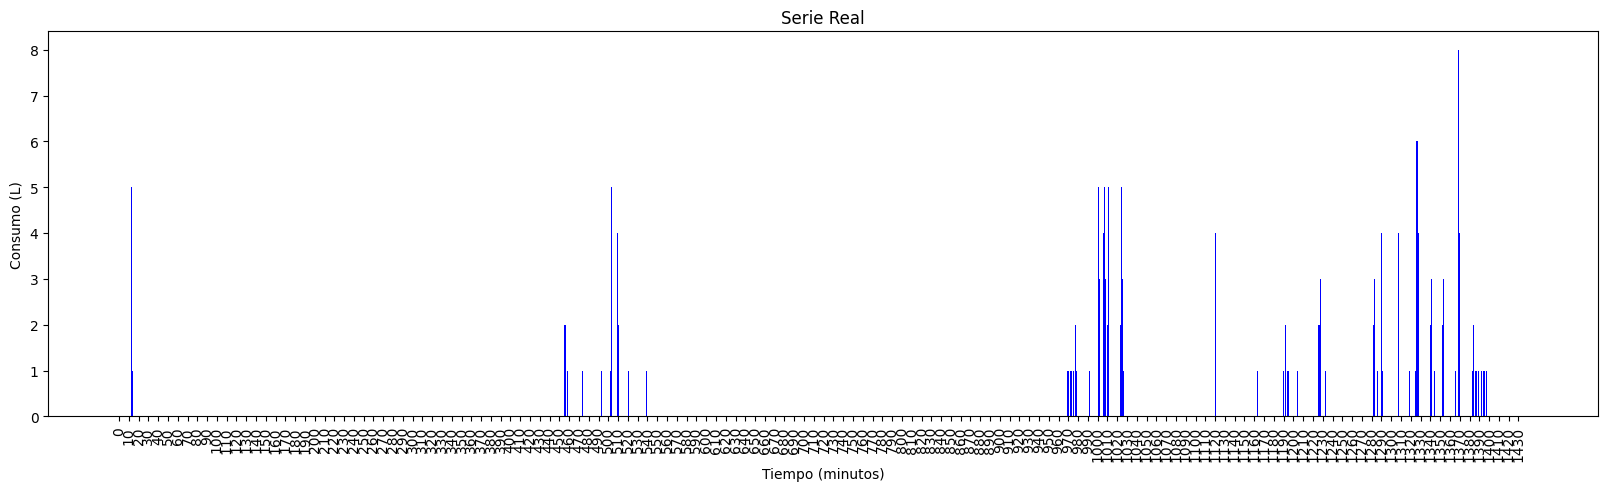

In [28]:
visualizar_serie_temporal(serie_real, f'Serie Real', 'Tiempo (minutos)', 'Consumo (L)', x_inicio = 0, x_fin = 1440, x_intervalo = 10)

# 4. Ejecución

## 4.1. Clustering borroso

In [29]:
fce = FuzzyClusteringEventos()
fce.fit(consumos_simulados.obtener_eventos())
df_clusteres = fce.obtener_dataset_resultados()
df_clusteres

,serie,max_vol,duracion,intensidad,total_vol,gp_g1,gp_g2,gp_g3,gp_g4,gp_g5
id_muestra,,,,,,,,,,
e01676d7-1010-4c5a-b10b-545ac7c1bf48,[2],0.090909,1,2.00,2,0.0,0.0,0.0,0.000,1.000
d4ef5a1f-06fe-4aaa-b39d-72bd6bcad543,[5],0.363636,1,5.00,5,0.0,0.0,0.0,0.000,0.000
d222a5f2-1662-48b2-a25c-c70bcff5375b,[3],0.181818,1,3.00,3,0.0,0.0,0.0,0.000,0.333
22633e2f-b43e-4579-952c-53a0032aeddb,[2],0.090909,1,2.00,2,0.0,0.0,0.0,0.000,1.000
ab2d0b6b-ae2e-4945-9f3b-976a980fd95d,"[2, 1]",0.090909,2,1.50,3,0.0,0.0,0.0,0.000,0.667
...,...,...,...,...,...,...,...,...,...,...
d554eb0c-fdf1-4fa7-ac51-80f5f4417003,"[3, 2, 4]",0.300000,3,3.00,9,0.0,0.0,0.0,0.333,0.000
5f557648-8531-43bc-8e26-c6d52d004ebb,"[1, 2]",0.100000,2,1.50,3,0.0,0.0,0.0,0.000,0.667
d309f73a-7ecb-498d-98b9-c6ea44b7a445,"[2, 2, 3, 2]",0.200000,4,2.25,9,0.0,0.0,0.0,0.000,0.000


## 4.2. Validación de los resultados

### 4.2.1. Representación

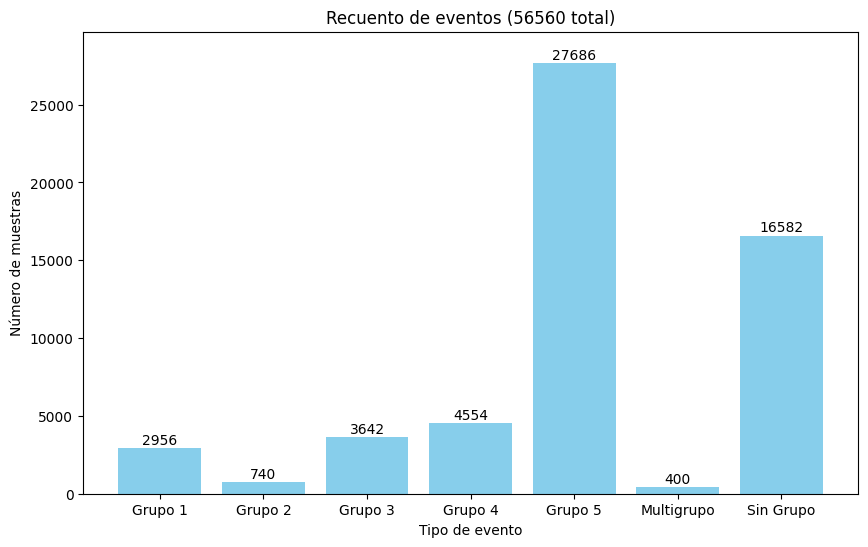

In [30]:
n_muestras_gp_g1 = df_clusteres[(df_clusteres.gp_g1 > 0) & (df_clusteres.gp_g1 > df_clusteres.gp_g2) & (df_clusteres.gp_g1 > df_clusteres.gp_g3) & (df_clusteres.gp_g1 > df_clusteres.gp_g4) & (df_clusteres.gp_g1 > df_clusteres.gp_g5)].shape[0]
n_muestras_gp_g2 = df_clusteres[(df_clusteres.gp_g2 > 0) & (df_clusteres.gp_g2 > df_clusteres.gp_g1) & (df_clusteres.gp_g2 > df_clusteres.gp_g3) & (df_clusteres.gp_g2 > df_clusteres.gp_g4) & (df_clusteres.gp_g2 > df_clusteres.gp_g5)].shape[0]
n_muestras_gp_g3 = df_clusteres[(df_clusteres.gp_g3 > 0) & (df_clusteres.gp_g3 > df_clusteres.gp_g2) & (df_clusteres.gp_g3 > df_clusteres.gp_g1) & (df_clusteres.gp_g3 > df_clusteres.gp_g4) & (df_clusteres.gp_g3 > df_clusteres.gp_g5)].shape[0]
n_muestras_gp_g4 = df_clusteres[(df_clusteres.gp_g4 > 0) & (df_clusteres.gp_g4 > df_clusteres.gp_g2) & (df_clusteres.gp_g4 > df_clusteres.gp_g3) & (df_clusteres.gp_g4 > df_clusteres.gp_g1) & (df_clusteres.gp_g4 > df_clusteres.gp_g5)].shape[0]
n_muestras_gp_g5 = df_clusteres[(df_clusteres.gp_g5 > 0) & (df_clusteres.gp_g5 > df_clusteres.gp_g2) & (df_clusteres.gp_g5 > df_clusteres.gp_g3) & (df_clusteres.gp_g5 > df_clusteres.gp_g4) & (df_clusteres.gp_g5 > df_clusteres.gp_g1)].shape[0]
n_muestras_sin_grupo = df_clusteres[df_clusteres.gp_g1 + df_clusteres.gp_g2 + df_clusteres.gp_g3 + df_clusteres.gp_g4 + df_clusteres.gp_g5 == 0].shape[0]
n_muestras_multigrupo = df_clusteres[(df_clusteres[["gp_g2", "gp_g3"]] > 0).sum(axis=1) > 1].shape[0]
etiquetas = ['Grupo 1', 'Grupo 2', 'Grupo 3', 'Grupo 4', 'Grupo 5', 'Multigrupo', 'Sin Grupo']
valores = [n_muestras_gp_g1, n_muestras_gp_g2, n_muestras_gp_g3, n_muestras_gp_g4, n_muestras_gp_g5, n_muestras_multigrupo, n_muestras_sin_grupo]
plt.figure(figsize=(10, 6))
bars = plt.bar(etiquetas, valores, color='skyblue')
plt.xlabel('Tipo de evento')
plt.ylabel('Número de muestras')
plt.title(f'Recuento de eventos ({sum(valores)} total)')
plt.ylim(0, max(valores) + 2000)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), ha='center', va='bottom')

plt.show()

### 4.2.2. Validación interna

In [31]:
df_sin_grupo = df_clusteres[df_clusteres.gp_g1 + df_clusteres.gp_g2 + df_clusteres.gp_g3 + df_clusteres.gp_g4 + df_clusteres.gp_g5 == 0][["serie", "max_vol", "duracion", "intensidad", "total_vol"]]
# df_sin_grupo.to_excel(f"{os.environ.get('RUTA_DATASETS')}eventos_sin_grupo.xlsx", index=True)
df_fragmentos_ed = extraer_posibles_fragmentos_de_ed(df_sin_grupo)

Filtrado de eventos continuos de bajo consumo

In [32]:
df_sin_grupo[(df_sin_grupo["posible_frag_ed"] == 0) & (df_sin_grupo["duracion"] > 3)]

,serie,max_vol,duracion,intensidad,total_vol,posible_frag_ed
id_muestra,,,,,,
2997a27a-d838-49ea-8e59-a755fb6855fa,"[1, 2, 2, 4]",0.230769,4,2.250000,9,0
2997a27a-d838-49ea-8e59-a755fb6855fa,"[1, 2, 2, 4]",0.230769,4,2.250000,9,0
bc8113db-0847-42ba-bd4a-b8f26152cb19,"[7, 6, 7, 5]",0.545455,4,6.250000,25,0
228bd6ac-6f68-4b8e-9cd8-86d098226a1d,"[7, 7, 7, 5]",0.545455,4,6.500000,26,0
c2d44a7a-293e-458c-bb48-9397497627b1,"[7, 6, 7, 5]",0.545455,4,6.250000,25,0
...,...,...,...,...,...,...
d02d10b7-46ec-42a5-8462-467e43edf180,"[1, 2, 3, 2, 1]",0.200000,5,1.800000,9,0
d0805eb5-d040-471c-8b17-d7c51f656f49,"[2, 3, 2, 2]",0.200000,4,2.250000,9,0
e4ca4878-6a60-4233-afc9-ea098ea8e03d,"[2, 2, 3, 3, 3, 2, 3]",0.200000,7,2.571429,18,0


Comparación con las series temporales sintéticas

In [33]:
def obtener_usos_originales(id_evento: str) -> pd.DataFrame:
  consumo = consumos_simulados.obtener_consumo_por_id_evento(id_evento)
  df_consumo = pd.read_excel(obtener_ruta_archivo(consumo.casa, consumo.parte), sheet_name=consumo.dia, header=None, index_col=0).iloc[3:].astype(int)
  series_grifos_indiv = df_consumo.loc[["Otap (L)", "Ktap (L)"]]
  serie_grifos_suma = series_grifos_indiv.sum(axis=0)
  df_consumo = df_consumo.drop(["Otap (L)", "Ktap (L)"])
  df_consumo.loc['taps'] = serie_grifos_suma
  df_consumo = df_consumo.rename(index={'WC (L)': 'wc', 'Bath (L)': 'bath', 'Shower (L)': 'shower', 'Dishw (L)': 'dishw', 'Washm (L)': 'washm'})
  return df_consumo

In [34]:
def contiene_evento(serie: list[int], serie_evento: list[int]) -> bool:
  serie_str = ','.join(map(str, serie))
  serie_evento_str = ','.join(map(str, [0] + serie_evento + [0]))
  return serie_evento_str in serie_str

In [35]:
def comparar_tipo_uso(dataset) -> pd.DataFrame:
  resultados = []
  i = 0
  for id_muestra, fila_evento in dataset.iterrows():
    usos_originales = obtener_usos_originales(id_muestra)
    for uso, serie_uso in usos_originales.iterrows():
      df_resultado = usos_originales[usos_originales.apply(lambda serie: contiene_evento(serie, fila_evento["serie"]), axis=1)]
    df_resultado = df_resultado.reset_index()
    df_resultado.rename(columns={0: 'uso'}, inplace=True)
    df_resultado["gp_g1"] = fila_evento["gp_g1"]
    df_resultado["gp_g2"] = fila_evento["gp_g2"]
    df_resultado["gp_g3"] = fila_evento["gp_g3"]
    df_resultado["gp_g4"] = fila_evento["gp_g4"]
    df_resultado["gp_g5"] = fila_evento["gp_g5"]
    df_resultado["id_muestra"] = id_muestra
    df_resultado.set_index("id_muestra", inplace=True)
    resultados.append(df_resultado[["uso", "gp_g1", "gp_g2", "gp_g3", "gp_g4", "gp_g5"]])
  return pd.concat(resultados)

In [36]:
n_g1, n_g2, n_g3, n_g4, n_g5 = 886, 222, 1092, 1366, 8305 # 10, 20, 14, 23, 18
df_g1 = df_clusteres[(df_clusteres.gp_g1 > 0) & (df_clusteres.gp_g1 > df_clusteres.gp_g2) & (df_clusteres.gp_g1 > df_clusteres.gp_g3) & (df_clusteres.gp_g1 > df_clusteres.gp_g4) & (df_clusteres.gp_g1 > df_clusteres.gp_g5)].sample(n=n_g1)
df_g2 = df_clusteres[(df_clusteres.gp_g2 > 0) & (df_clusteres.gp_g2 > df_clusteres.gp_g1) & (df_clusteres.gp_g2 > df_clusteres.gp_g3) & (df_clusteres.gp_g2 > df_clusteres.gp_g4) & (df_clusteres.gp_g2 > df_clusteres.gp_g5)].sample(n=n_g2)
df_g3 = df_clusteres[(df_clusteres.gp_g3 > 0) & (df_clusteres.gp_g3 > df_clusteres.gp_g2) & (df_clusteres.gp_g3 > df_clusteres.gp_g1) & (df_clusteres.gp_g3 > df_clusteres.gp_g4) & (df_clusteres.gp_g3 > df_clusteres.gp_g5)].sample(n=n_g3)
df_g4 = df_clusteres[(df_clusteres.gp_g4 > 0) & (df_clusteres.gp_g4 > df_clusteres.gp_g2) & (df_clusteres.gp_g4 > df_clusteres.gp_g3) & (df_clusteres.gp_g4 > df_clusteres.gp_g1) & (df_clusteres.gp_g4 > df_clusteres.gp_g5)].sample(n=n_g4)
df_g5 = df_clusteres[(df_clusteres.gp_g5 > 0) & (df_clusteres.gp_g5 > df_clusteres.gp_g2) & (df_clusteres.gp_g5 > df_clusteres.gp_g3) & (df_clusteres.gp_g5 > df_clusteres.gp_g4) & (df_clusteres.gp_g5 > df_clusteres.gp_g1)].sample(n=n_g5)

In [37]:
comparacion_g1 = comparar_tipo_uso(df_g1)
comparacion_g2 = comparar_tipo_uso(df_g2)
comparacion_g3 = comparar_tipo_uso(df_g3)
comparacion_g4 = comparar_tipo_uso(df_g4)
comparacion_g5 = comparar_tipo_uso(df_g5)

In [38]:
resultados_g1 = {
    "esperados": ((comparacion_g1['uso'] == 'bath') | (comparacion_g1['uso'] == 'shower')).sum(),
    "grifos": (comparacion_g1['uso'] == "taps").sum(),
    "incorrectos": ((comparacion_g1['uso'] != 'bath') & (comparacion_g1['uso'] != 'shower') & (comparacion_g1['uso'] != 'taps')).sum(),
  }
resultados_g2 = {
    "esperados": ((comparacion_g2['uso'] == 'washm')).sum(),
    "grifos": (comparacion_g2['uso'] == "taps").sum(),
    "incorrectos": ((comparacion_g2['uso'] != 'washm') & (comparacion_g2['uso'] != 'taps')).sum(),
  }
resultados_g3 = {
    "esperados": ((comparacion_g3['uso'] == 'dishw') | (comparacion_g3['uso'] == 'washm')).sum(),
    "grifos": (comparacion_g3['uso'] == "taps").sum(),
    "incorrectos": ((comparacion_g3['uso'] != 'dishw') & (comparacion_g3['uso'] != 'washm') & (comparacion_g3['uso'] != 'taps')).sum(),
  }
resultados_g4 = {
    "esperados": ((comparacion_g4['uso'] == 'wc') | (comparacion_g4['uso'] == 'dishw')).sum(),
    "grifos": (comparacion_g4['uso'] == "taps").sum(),
    "incorrectos": ((comparacion_g4['uso'] != 'wc') & (comparacion_g4['uso'] != 'dishw') & (comparacion_g4['uso'] != 'taps')).sum(),
  }
resultados_g5 = {
    "esperados": ((comparacion_g5['uso'] == 'wc')).sum(),
    "grifos": (comparacion_g5['uso'] == "taps").sum(),
    "incorrectos": ((comparacion_g5['uso'] != 'wc') & (comparacion_g5['uso'] != 'taps')).sum(),
  }

resultados = [resultados_g1, resultados_g2, resultados_g3, resultados_g4, resultados_g5]

In [39]:
comparacion_g1

,uso,gp_g1,gp_g2,gp_g3,gp_g4,gp_g5
id_muestra,,,,,,
3b5ae81e-8efb-4be4-8144-765db2983aa6,shower,0.636,0.0,0.0,0.0,0.0
4b5a1400-203b-4027-8c87-13fe5befbbd0,shower,0.636,0.0,0.0,0.0,0.0
d87abd8d-95e2-472e-8fc8-eddae41cb6ab,taps,1.000,0.0,0.0,0.0,0.0
d8040f3d-4fb7-477b-a9b0-1be26834e9ff,shower,0.182,0.0,0.0,0.0,0.0
9c0be11a-5535-4874-be06-03efc2954dd6,shower,0.182,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
478a52ef-e98e-44b4-a7d7-8e35e69a6f06,shower,0.333,0.0,0.0,0.0,0.0
ab87718d-90d3-402e-9527-768664bf1387,shower,1.000,0.0,0.0,0.0,0.0
c1ee7dc6-f938-4598-8b83-f08a6e972e95,shower,1.000,0.0,0.0,0.0,0.0


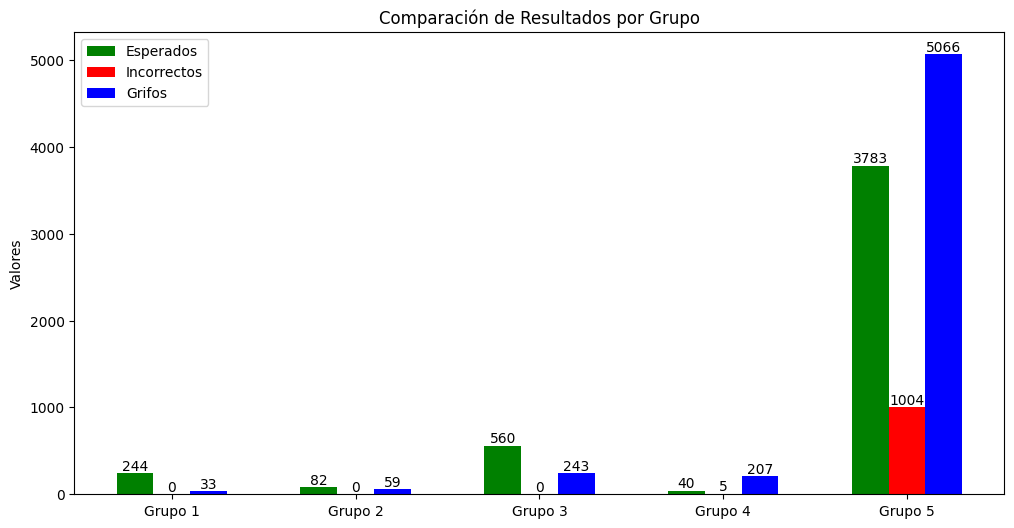

In [40]:
categorias = {
    "esperados": "Esperados",
    "incorrectos": "Incorrectos",
    "grifos": "Grifos"
  }
colores = ['green', 'red', 'blue']

n_grupos = len(resultados)
n_barras = len(categorias)

indice_barras = np.arange(n_grupos)
ancho_barra = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

for i, (categoria, color) in enumerate(zip(categorias.keys(), colores)):
  valores = [resultado[categoria] for resultado in resultados]
  barras = ax.bar(indice_barras + i * ancho_barra, valores, ancho_barra, label=categorias[categoria], color=color)
  for barra in barras:
    altura = barra.get_height()  # Obtener la altura (valor) de cada barra
    ax.text(barra.get_x() + barra.get_width() / 2, altura, f'{int(altura)}', ha='center', va='bottom')

ax.set_ylabel('Valores')
ax.set_title('Comparación de Resultados por Grupo')
ax.set_xticks(indice_barras + ancho_barra * (n_barras - 1) / 2)
ax.set_xticklabels([f'Grupo {i+1}' for i in range(n_grupos)])
ax.legend()

plt.show()